In [1]:
import importlib
import os
from joblib import dump, load

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# from nltk import download as nltk_download
from nltk import tokenize, RegexpTokenizer, FreqDist
# from nltk.corpus import stopwords
# nltk_download('wordnet')
# nltk_download('punkt')
# nltk_download('stopwords')
# from nltk.stem.snowball import SnowballStemmer

import ml.prepare as mlprepare
# import spacy

# import tensorflow as tf


data_path = "..\\data\\stackoverflow\\"
model_path = data_path + "models\\"

np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = "{:,.2f}".format


# tfds.disable_progress_bar()

In [2]:
bs4_filename = 'bs4.pkl'
top_tags_filename = 'Top_Tags.pkl'
df_bs4_base = pd.read_pickle(data_path + bs4_filename)
df_top = pd.read_pickle(data_path + top_tags_filename)
# body_corpus = load(data_path + 'body_corpus.joblib')

In [3]:
# df_tags = pd.read_pickle(data_path + 'Top_Tags.pkl')

# mlb = MultiLabelBinarizer()
# y_tags = mlb.fit_transform(df_tags['Tags_T50'])
# y_tag_python = y_tags[:,np.where(mlb.classes_=="python")]

# Exploratory Data Analysis

## bs4 parsed data / Frequency analysis per tag (Top10)

In [3]:
def nltk_tokenize(row):
    tokenizer = RegexpTokenizer(r'\w+')
    title_tokens = [ w for w in tokenizer.tokenize(row['Title'].lower()) ] 
    body_tokens = [ w for w in tokenizer.tokenize(row['Bs4_Body'].lower()) ]
    return title_tokens, body_tokens

def filter_on_tag(row, tag):
    if tag in row['Tags']:
        return True
    else:
        return False

In [4]:
df_bs4_init = pd.concat(
    [df_bs4_base[['Title', 'Bs4_Body']].apply(nltk_tokenize, axis=1, result_type='expand'),
    df_top['Tags_T10']], axis=1)
df_bs4_init.columns = ['Title', 'Bs4_Body','Tags']

In [5]:
# Warning full dataset takes a while to handle hence the record count limitation
# df_bs4_token = df_bs4_init[:20000].copy(deep=True)
df_bs4_token = df_bs4_init.copy(deep=True)
df_bs4_token

,Title,Bs4_Body,Tags
0,"[pandas, pivot, dataframe, where, values, are,...","[suppose, we, have, a, dataframe, i, want, to,...","[python, pandas, dataframe]"
1,"[using, polymorphic, function, as, a, parameter]","[i, have, a, function, which, accepts, 3, para...",[other]
2,"[loop, over, list, of, dictionaries, condition...","[i, m, looping, over, a, list, of, dictionarie...",[python]
3,"[using, cpquery, function, for, several, pairs...","[i, am, relatively, beginner, in, r, and, tryi...",[r]
4,"[split, numbers, delimited, by, any, non, nume...","[i, need, to, split, a, string, with, numbers,...",[c#]
...,...,...,...
96415,"[replace, certain, child, value, if, doesn, t,...","[preface, this, is, the, first, xpath, and, do...",[other]
96416,"[updateradiogroupbuttons, removes, css]","[i, m, using, with, different, colors, based, ...",[r]
96417,"[react, set, state, after, every, foreach, api...","[i, have, a, block, of, code, that, looks, lik...",[javascript]
96418,"[array, pointer, type, for, function, return]","[i, started, using, array, pointers, a, lot, r...",[other]


In [6]:
top_tags = mlprepare.prepare_multi_label(df_bs4_token,'Tags')
top_tags

other         40310
python        18395
javascript    10757
r              7194
pandas         6971
c++            5626
java           5122
c#             3911
python-3.x     3864
sql            3785
dataframe      3782
dtype: int64

In [7]:
freq_title = {}
freq_body = {}
for tag in  top_tags.index:
    freq_title[tag] = FreqDist(df_bs4_token[df_bs4_token.apply(filter_on_tag, tag=tag, axis=1)]['Title'].sum()).most_common(20)
    freq_body[tag] = FreqDist(df_bs4_token[df_bs4_token.apply(filter_on_tag, tag=tag, axis=1)]['Bs4_Body'].sum()).most_common(20)
     

In [9]:
gen_freq = False
if gen_freq:
    freq_title = {}
    freq_body = {}
    for tag in  top_tags.index:
        freq_title[tag] = FreqDist(df_bs4_token[df_bs4_token.apply(filter_on_tag, tag=tag, axis=1)]['Title'].sum()).most_common(20)
        freq_body[tag] = FreqDist(df_bs4_token[df_bs4_token.apply(filter_on_tag, tag=tag, axis=1)]['Bs4_Body'].sum()).most_common(20)
    dump(freq_title, data_path + 'EDA_bs4_freq_title.joblib')
    dump(freq_body, data_path + 'EDA_bs4_freq_body.joblib')
else:
    print('else')
#     freq_title = load(data_path + 'EDA_bs4_freq_title.joblib')
#     freq_body = load(data_path + 'EDA_bs4_freq_body.joblib')

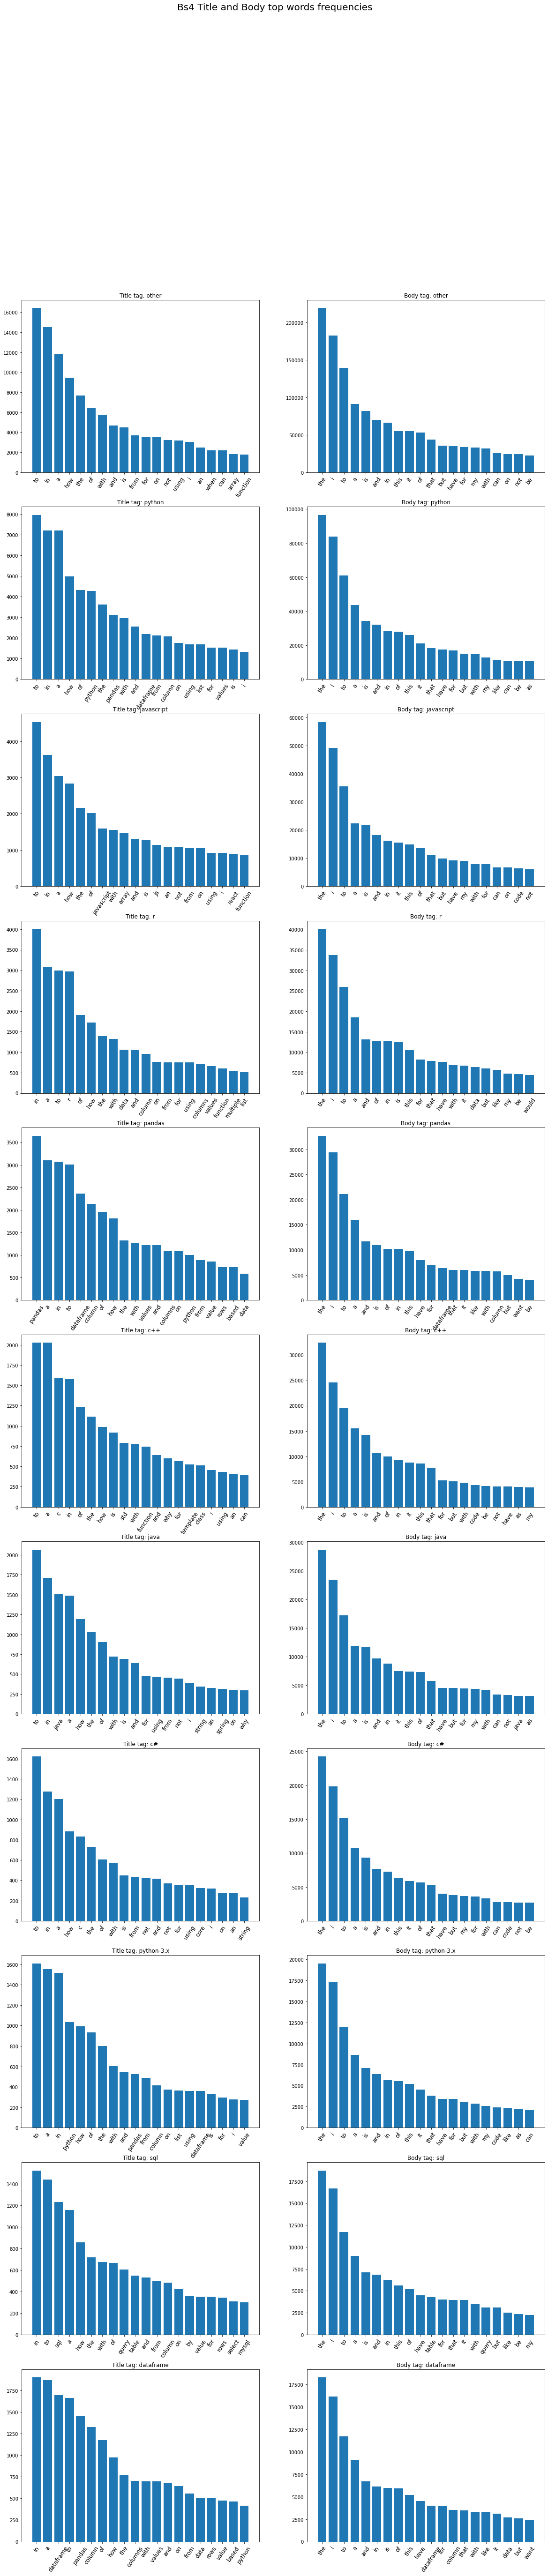

In [10]:
fig, axs = plt.subplots(len(top_tags.index),2,figsize=(20,8*len(top_tags.index)))
fig.suptitle('Bs4 Title and Body top words frequencies', fontsize=20)
c=0
for tag in top_tags.index:
    title_words = list(zip(*freq_title[tag]))[0]
    title_count = list(zip(*freq_title[tag]))[1]
    body_words = list(zip(*freq_body[tag]))[0]
    body_count = list(zip(*freq_body[tag]))[1]
    axs[c,0].bar(title_words,title_count)
    axs[c,0].set_xticks(axs[c,0].get_xticks())
    axs[c,0].set_xticklabels(title_words, rotation=55, fontsize=12)
    axs[c,0].set_title('Title tag: ' + tag)
    axs[c,1].bar(body_words, body_count)
    axs[c,1].set_xticks(axs[c,1].get_xticks())
    axs[c,1].set_xticklabels(body_words, rotation=55, fontsize=12)
    axs[c,1].set_title('Body tag: ' + tag)
    c=c+1

## Stopless and stemmed data / Frequency analysis per tag (Top10)

In [11]:
stem_filename = 'nltk_stop_stem.pkl'
top_tags_filename = 'Top_Tags.pkl'
df_stem_base = pd.read_pickle(data_path + stem_filename)
df_top = pd.read_pickle(data_path + top_tags_filename)

In [12]:
def filter_on_tag(row, tag):
    if tag in row['Tags']:
        return True
    else:
        return False

In [13]:
df_stem_init = pd.concat(
    [df_stem_base,
    df_top['Tags_T10']], axis=1)
df_stem_init.columns = ['Title', 'Bs4_Body','Tags']

In [14]:
# df_stem_token = df_stem_init[:2000].copy(deep=True)
df_stem_token = df_stem_init.copy(deep=True)
df_stem_token

,Title,Bs4_Body,Tags
0,"[panda, pivot, datafram, valu, function, two, ...","[suppos, datafram, sort, pivot, datafram, colu...","[python, pandas, dataframe]"
1,"[polymorph, function, paramet]","[function, accept, 3, paramet, appli, function...",[other]
2,"[loop, list, dictionari, condit, key, exist]","[loop, list, dictionari, python, dictionari, c...",[python]
3,"[cpqueri, function, sever, pair, dataset]","[relat, beginn, r, tri, figur, cpqueri, functi...",[r]
4,"[split, number, delimit, ani, non, numer, string]","[split, string, number, separ, ani, non, numer...",[c#]
...,...,...,...
96415,"[replac, certain, child, valu, contain, certai...","[prefac, first, xpath, dom, script, ever, work...",[other]
96416,"[updateradiogroupbutton, remov, css]","[differ, color, base, https, github, com, drea...",[r]
96417,"[react, set, state, everi, foreach, api, reque...","[block, look, like, element, array, make, call...",[javascript]
96418,"[array, pointer, type, function, return]","[start, array, pointer, lot, recent, becaus, s...",[other]


In [15]:
top_tags = mlprepare.prepare_multi_label(df_stem_token,'Tags')
top_tags

other         40310
python        18395
javascript    10757
r              7194
pandas         6971
c++            5626
java           5122
c#             3911
python-3.x     3864
sql            3785
dataframe      3782
dtype: int64

In [ ]:
gen_stem_freq = False
if gen_stem_freq:
    stem_freq_title = {}
    stem_freq_body = {}
    for tag in  top_tags.index:
        stem_freq_title[tag] = FreqDist(df_stem_token[df_stem_token.apply(filter_on_tag, tag=tag, axis=1)]['Title'].sum()).most_common(20)
        stem_freq_body[tag] = FreqDist(df_stem_token[df_stem_token.apply(filter_on_tag, tag=tag, axis=1)]['Bs4_Body'].sum()).most_common(20)    
    dump(stem_freq_title, data_path + 'EDA_stem_freq_title.joblib')
    dump(stem_freq_body, data_path + 'EDA_stem_freq_body.joblib')
else:
    stem_freq_title = load(data_path + 'EDA_stem_freq_title.joblib')
    stem_freq_body = load(data_path + 'EDA_stem_freq_body.joblib')

## Lemma and Stopless data / Frequency analysis per tag (Top10)

In [18]:
lemma_filename = 'nltk_lemma_stop.pkl'
top_tags_filename = 'Top_Tags.pkl'
df_lemma_base = pd.read_pickle(data_path + lemma_filename)
df_top = pd.read_pickle(data_path + top_tags_filename)

In [19]:
def filter_on_tag(row, tag):
    if tag in row['Tags']:
        return True
    else:
        return False

In [20]:
df_lemma_init = pd.concat(
    [df_lemma_base,
    df_top['Tags_T10']], axis=1)
df_lemma_init.columns = ['Title', 'Bs4_Body','Tags']

In [21]:
# df_lemma_token = df_lemma_init[:2000].copy(deep=True)
df_lemma_token = df_lemma_init.copy(deep=True)
df_lemma_token

,Title,Bs4_Body,Tags
0,"[panda, pivot, dataframe, value, function, two...","[suppose, dataframe, sort, pivot, dataframe, c...","[python, pandas, dataframe]"
1,"[polymorphic, function, parameter]","[function, accepts, 3, parameter, applies, fun...",[other]
2,"[loop, list, dictionary, conditional, key, exist]","[loop, list, dictionary, python, dictionary, c...",[python]
3,"[cpquery, function, several, pair, dataset]","[relatively, beginner, r, figure, cpquery, fun...",[r]
4,"[split, number, delimit, non, numeric, string]","[split, string, number, separate, non, numeric...",[c#]
...,...,...,...
96415,"[replace, certain, child, value, contain, cert...","[preface, first, xpath, dom, script, ever, wor...",[other]
96416,"[updateradiogroupbuttons, remove, cs]","[different, color, base, http, github, com, dr...",[r]
96417,"[react, set, state, every, foreach, api, reque...","[block, look, like, element, array, make, call...",[javascript]
96418,"[array, pointer, type, function, return]","[start, array, pointer, lot, recently, simplif...",[other]


In [22]:
top_tags = mlprepare.prepare_multi_label(df_lemma_token,'Tags')
top_tags

other         40310
python        18395
javascript    10757
r              7194
pandas         6971
c++            5626
java           5122
c#             3911
python-3.x     3864
sql            3785
dataframe      3782
dtype: int64

In [23]:
gen_lemma_freq = True
if gen_lemma_freq:
    lemma_freq_title = {}
    lemma_freq_body = {}
    for tag in  top_tags.index:
        lemma_freq_title[tag] = FreqDist(df_lemma_token[df_lemma_token.apply(filter_on_tag, tag=tag, axis=1)]['Title'].sum()).most_common(20)
        lemma_freq_body[tag] = FreqDist(df_lemma_token[df_lemma_token.apply(filter_on_tag, tag=tag, axis=1)]['Bs4_Body'].sum()).most_common(20)
    dump(lemma_freq_title, data_path + 'EDA_lemma_freq_title.joblib')
    dump(lemma_freq_body, data_path + 'EDA_lemma_freq_body.joblib')
else:
    lemma_freq_title = load(data_path + 'EDA_lemma_freq_title.joblib')
    lemma_freq_body = load(data_path + 'EDA_lemma_freq_body.joblib')

In [28]:
freqs = {
    'body': {
        'bs4': freq_body,
        'stem': stem_freq_body,
        'lemma': lemma_freq_body
    },
    'title': {
        'bs4': freq_title,
        'stem': stem_freq_title,
        'lemma': lemma_freq_title        
    }
}

In [29]:
# dump(freqs, data_path + 'EDA_freqs.joblib' )
freqs = load(data_path + 'EDA_freqs.joblib')

['..\\data\\stackoverflow\\EDA_freqs.joblib']

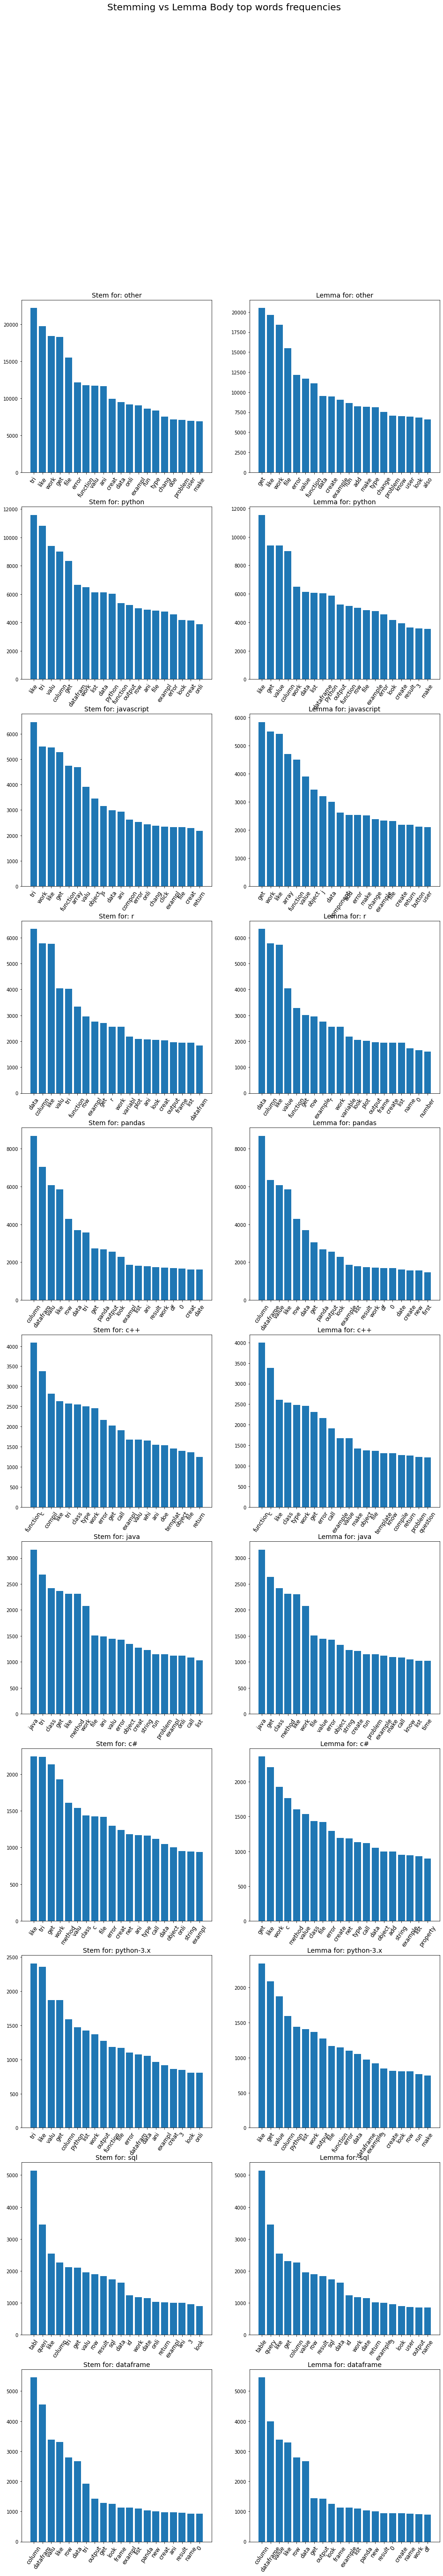

In [30]:
fig, axs = plt.subplots(len(top_tags.index),2,figsize=(16, 8*len(top_tags.index)))

c=0
for tag in top_tags.index:
    words_stem = list(zip(*freqs['body']['stem'][tag]))[0]
    count_stem = list(zip(*freqs['body']['stem'][tag]))[1]
    words_lemma = list(zip(*freqs['body']['lemma'][tag]))[0]
    count_lemma = list(zip(*freqs['body']['lemma'][tag]))[1]
    
    axs[c,0].bar(words_stem,count_stem)
    axs[c,0].set_xticks(axs[c,0].get_xticks())
    axs[c,0].set_xticklabels(words_stem, rotation=55, fontsize=12)
    axs[c,0].set_title('Stem for: ' + tag, fontsize=14)
    axs[c,1].bar(words_lemma,count_lemma)
    axs[c,1].set_xticks(axs[c,1].get_xticks())
    axs[c,1].set_xticklabels(words_lemma, rotation=55, fontsize=12)
    axs[c,1].set_title('Lemma for: ' + tag, fontsize=14)
    c=c+1
    
fig.suptitle('Stemming vs Lemma Body top words frequencies', fontsize=20)
plt.show()

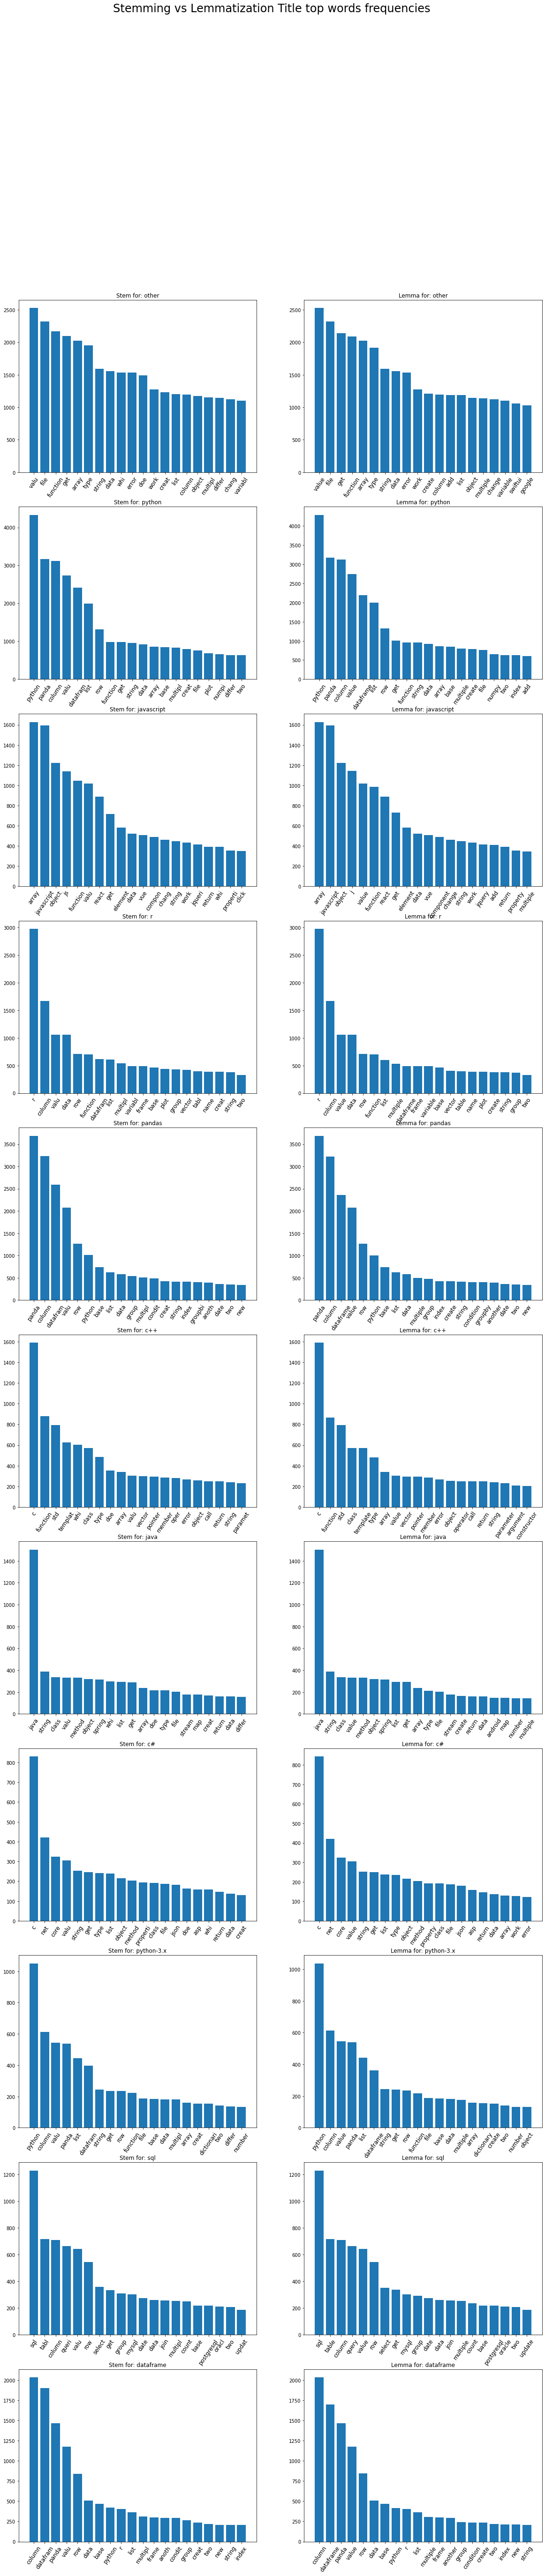

In [79]:
fig, axs = plt.subplots(len(top_tags.index),2,figsize=(20,8*len(top_tags.index)))
fig.suptitle('Stemming vs Lemmatization Title top words frequencies', fontsize=24)
c=0
for tag in top_tags.index:
    words_stem = list(zip(*freqs['title']['stem'][tag]))[0]
    count_stem = list(zip(*freqs['title']['stem'][tag]))[1]
    words_lemma = list(zip(*freqs['title']['lemma'][tag]))[0]
    count_lemma = list(zip(*freqs['title']['lemma'][tag]))[1]
    
    axs[c,0].bar(words_stem,count_stem)
    axs[c,0].set_xticks(axs[c,0].get_xticks())
    axs[c,0].set_xticklabels(words_stem, rotation=55, fontsize=12)
    axs[c,0].set_title('Stem for: ' + tag)
    axs[c,1].bar(words_lemma,count_lemma)
    axs[c,1].set_xticks(axs[c,1].get_xticks())
    axs[c,1].set_xticklabels(words_lemma, rotation=55, fontsize=12)
    axs[c,1].set_title('Lemma for: ' + tag)
    c=c+1

# LDA

In [32]:
lemma_filename = 'nltk_lemma_stop.pkl'
top_tags_filename = 'Top_Tags.pkl'
df_lemma_base = pd.read_pickle(data_path + lemma_filename)
df_top = pd.read_pickle(data_path + top_tags_filename)

In [33]:
df_lemma_init = pd.concat(
    [df_lemma_base,
    df_top['Tags_T10']], axis=1)
df_lemma_init.columns = ['Title', 'Bs4_Body','Tags']

In [34]:
# df_lemma_token = df_lemma_init[:2000].copy(deep=True)
df_lemma_token = df_lemma_init.copy(deep=True)
df_lemma_token

,Title,Bs4_Body,Tags
0,"[panda, pivot, dataframe, value, function, two...","[suppose, dataframe, sort, pivot, dataframe, c...","[python, pandas, dataframe]"
1,"[polymorphic, function, parameter]","[function, accepts, 3, parameter, applies, fun...",[other]
2,"[loop, list, dictionary, conditional, key, exist]","[loop, list, dictionary, python, dictionary, c...",[python]
3,"[cpquery, function, several, pair, dataset]","[relatively, beginner, r, figure, cpquery, fun...",[r]
4,"[split, number, delimit, non, numeric, string]","[split, string, number, separate, non, numeric...",[c#]
...,...,...,...
96415,"[replace, certain, child, value, contain, cert...","[preface, first, xpath, dom, script, ever, wor...",[other]
96416,"[updateradiogroupbuttons, remove, cs]","[different, color, base, http, github, com, dr...",[r]
96417,"[react, set, state, every, foreach, api, reque...","[block, look, like, element, array, make, call...",[javascript]
96418,"[array, pointer, type, function, return]","[start, array, pointer, lot, recently, simplif...",[other]


In [35]:
body_vectorizer = load(model_path + 'lemma_body_count_vectorizer_13.joblib')
# body_vectorizer = load(model_path + 'lemma_body_vectorizer_12.joblib')
df_body = df_lemma_token['Bs4_Body'].apply(lambda row: ' '.join(row))
X_body = body_vectorizer.transform(df_body)[:25000]
X_body.shape

(25000, 4000)

In [36]:
df_body = df_lemma_token['Bs4_Body'].apply(lambda row: ' '.join(row))

In [37]:
X_body = body_vectorizer.transform(df_body)[:25000]
X_body.shape

(25000, 4000)

In [81]:
from sklearn.model_selection import GridSearchCV

class MyLDAWithPerplexityScorer(LatentDirichletAllocation):

    def score(self, X, y=None):

        # You can change the options passed to perplexity here
        score = super(MyLDAWithPerplexityScorer, self).perplexity(X, sub_sampling=False)

        # Since perplexity is lower for better, so we do negative
        return -1*score

search_params = {
#     'n_components': [ 30,  50, 75, 100],
    'n_components': np.arange(10)+1,    
    'learning_decay': [.5, .7, .9],
#     'learning_decay': [.7],    
    'max_iter': [10], 
    'learning_method': ['online'], 
#         learning_offset=25.,
#         random_state=42,
#     'n_jobs': [8],

}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params,n_jobs=6)
model.fit(X_body)

GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=6,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['online'], 'max_iter': [10],
                         'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])})

In [82]:
best_lda = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda.perplexity(X_body))

Best Model's Params:  {'learning_decay': 0.5, 'learning_method': 'online', 'max_iter': 10, 'n_components': 3}
Best Log Likelihood Score:  -991635.6603535874
Model Perplexity:  676.8498147954006


In [83]:
model.cv_results_

{'mean_fit_time': array([ 15.71,  75.92,  83.25,  79.1 ,  81.49,  82.08,  80.47,  80.79,
         79.33,  79.54,  21.76,  98.48, 106.88,  93.13,  81.13,  75.3 ,
         74.94,  75.59,  76.21,  76.17,  17.86,  92.16, 100.12,  97.62,
         94.75,  93.93,  94.94,  89.48,  84.89,  72.73]),
 'std_fit_time': array([0.68, 4.92, 2.72, 6.2 , 1.9 , 1.62, 1.16, 1.17, 1.7 , 1.64, 0.11,
        4.9 , 1.66, 4.8 , 4.03, 1.47, 1.75, 1.41, 0.88, 1.35, 0.15, 4.19,
        0.97, 2.59, 2.17, 1.02, 2.35, 2.92, 2.6 , 7.63]),
 'mean_score_time': array([0.57, 1.85, 2.19, 2.04, 1.99, 2.03, 1.96, 1.98, 1.93, 1.88, 0.69,
        2.34, 2.53, 1.98, 1.83, 1.8 , 1.8 , 1.79, 1.83, 1.82, 0.55, 2.16,
        2.34, 2.32, 2.28, 2.26, 2.21, 2.08, 2.03, 1.45]),
 'std_score_time': array([0.06, 0.15, 0.15, 0.05, 0.06, 0.04, 0.03, 0.06, 0.03, 0.06, 0.01,
        0.11, 0.08, 0.2 , 0.05, 0.04, 0.07, 0.14, 0.03, 0.06, 0.01, 0.09,
        0.04, 0.09, 0.04, 0.03, 0.13, 0.05, 0.05, 0.19]),
 'param_learning_decay': masked_array(

In [49]:

from sklearn.decomposition import LatentDirichletAllocation
n_topics = 30

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=10, 
        learning_method='online', 
        learning_offset=25.,
        random_state=42,
        n_jobs=6,)

# Fitter sur les données
lda.fit(X_body)

LatentDirichletAllocation(learning_method='online', learning_offset=25.0,
                          n_components=75, n_jobs=6, random_state=42)

In [45]:
lda.components_.shape

(20, 2000)

In [50]:
print(lda.score(X_body))
print(lda.perplexity(X_body))

-5448751.491485351
723.2295912927787


In [46]:
print(lda.score(X_body))
print(lda.perplexity(X_body))
50

-5178921.621995498
522.0123670823197


In [40]:
print(lda.score(X_body))
print(lda.perplexity(X_body))

-5333296.016324943
629.0569973719188


In [38]:
def create_topics(model, feature_names, no_top_words):
    topics_dict = {}
    for topic_idx, topic in enumerate(model.components_):
#         print("Topic {}:".format(topic_idx))
#         print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        topics_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    return topics_dict
no_top_words = 10
# display_topics(best_lda, body_vectorizer.get_feature_names(), no_top_words)

In [39]:
body_vectorizer = load(model_path + 'lemma_body_vectorizer_13.joblib')
# body_vectorizer = load(model_path + 'lemma_body_vectorizer_12.joblib')


In [40]:
df_body = df_lemma_token['Bs4_Body'].apply(lambda row: ' '.join(row))
# X_body = body_vectorizer.transform(df_body)[:50000]
X_body = body_vectorizer.transform(df_body)
X_body.shape

(96420, 4000)

In [77]:
from sklearn.decomposition import NMF

no_topics = 40

# Run NMF
nmf = NMF(
    n_components=no_topics,
    random_state=1,
    max_iter=100,
    alpha=.05,
    l1_ratio=.1,
    tol=1e-2,
    init='nndsvd')
nmf.fit(X_body)


NMF(alpha=0.05, init='nndsvd', l1_ratio=0.1, max_iter=50, n_components=40,
    random_state=1, tol=0.01)

In [78]:
no_top_words = 15
topics_dict = create_topics(nmf, body_vectorizer.get_feature_names(), no_top_words)
for key in topics_dict.keys():
    print (key, ":", ', '.join(topics_dict[key]))

0 : work, fine, work fine, make, seem, problem, solution, seem work, well, know, also, make work, understand, question, everything
1 : column, new column, column name, new, value column, column value, column column, two column, df, create, column like, first column, create new column, create new, dataset
2 : array, numpy, index, loop, array object, array like, array array, numpy array, sort, 2d, size, element array, two array, 2d array, value array
3 : file, folder, csv, directory, csv file, read, txt, json, xml, save, path, script, text file, json file, file name
4 : table, sql, insert, record, join, table table, data table, two table, id, table like, database, create, update, mysql, two
5 : error, get error, message, error message, give error, give, error error, fix, throw, throw error, compile, error get, syntax, get error message, get error error
6 : string, character, regex, match, word, replace, convert, space, remove, string like, letter, example, pattern, expression, split
7 : 

In [56]:
df_check = pd.concat(
    [df_bs4_base[['Title', 'Bs4_Body']].apply(nltk_tokenize, axis=1, result_type='expand'),
    df_top['Tags_T100']], axis=1)
df_check.columns = ['Title', 'Bs4_Body','Tags']

In [72]:
id = 26468
title = ' '.join(df_check.loc[id,'Title'])
texte = ' '.join(df_check.loc[id,'Bs4_Body'])
print(title)
print(texte)
print ("Tags: ", df_check.loc[id,'Tags'] )

how to increment each string element from one array that is found in another array
i ve kind of stuck on this problem the goal is to find matching values from column a in column b and increment same values by 1 only in column b this goes for single aswell as many character strings any help would be much appreciated thanks this is what i tried here is the link to the spreadsheet https docs google com spreadsheets d 1u55xvngrzfahedb1uwhqpcuxmtvtkwi lxdhtu30cwq edit usp sharing desired result screenshot problem when loging the values are but they should actually be
Tags:  ['javascript', 'google-apps-script', 'google-sheets']


In [73]:
# texte = "help on python dataframe"
X_texte = body_vectorizer.transform([texte])
nmf_array = nmf.transform(X_texte)

In [74]:
threshold = 0.007
for i in pd.DataFrame(nmf_array[0]).sort_values(by=[0],axis=0, ascending=False).index:
    if nmf_array[0][i] > threshold:
        print(nmf_array[0][i], "Match: ", topics_dict[i])

0.06206132902700744 Match:  ['column', 'name', 'column name', 'new column', 'new', 'value column', 'column value', 'column column', 'df', 'two column', 'column like', 'create', 'create new column', 'first column', 'create new']
0.024869384272875182 Match:  ['http', 'com', 'page', 'api', 'request', 'url', 'html', 'google', 'link', 'app', 'server', 'github', 'doc', 'www', 'service']
0.00863675652739055 Match:  ['query', 'result', 'return', 'sql', 'get', 'document', 'get result', 'expect', 'record', 'expect result', 'field', 'query get', 'sql query', 'query return', 'search']


0.033841373724222655
0.009724969201963734
0.009222456723428295
